In [1]:
import numpy as np
from scipy.io import loadmat
import networkx as nx
import matplotlib.pyplot as plt 

### Load data

In [2]:
def load_data(path = "market.mat",column = 'DI') :
    
    data = loadmat(path)[column]
    return data

In [3]:
data = load_data()
print(data.shape)

(7, 190, 12)


### Directed information Learning

In [4]:
def compute_DI_matrix(data) :
    
    # constant to recover from the shape of the data
    nb_company = data.shape[2]
    nb_sample = data.shape[1]
    T = data.shape[0]
    
    # initialize the DI matrix with zeros
    DI = np.zeros([nb_company,nb_company])
    
    # loop over all company combinations
    for X in range(nb_company) : 
        
        for Y in range(nb_company) :
            tmp = 0.0
            # check if x and y are different 
            if (X != Y) :
                
                # keep the indices of companies not in x or y
                comp = np.arange(nb_company)
                z = np.delete(comp,[X,Y])
                    
                # loop over the time
                for t in range(1,T) :
    
                    # get the data up to time t
                    x_t_1 = data[:t,:,X]
                    y_t_1 = data[:t,:,Y]
                    y_t = data[:(t+1),:,Y]
                    z_t_1 = data[:t,:,z]
                    z_t_1 = np.swapaxes(z_t_1,1,2)
                    z_t_1 = np.reshape(z_t_1,(-1,nb_sample))
                    
                    # get covariance matrices
                    cov_1 = np.cov(np.concatenate((y_t,z_t_1),axis=0))
                    cov_2 = np.cov(np.concatenate((x_t_1,y_t_1,z_t_1),axis=0))
                    cov_3 = np.cov(np.concatenate((y_t_1,z_t_1),axis=0))
                    cov_4 = np.cov(np.concatenate((x_t_1,y_t,z_t_1),axis=0))
                    
                    # compute determinant
                    det_1 = np.linalg.det(cov_1)
                    det_2 = np.linalg.det(cov_2)
                    det_3 = np.linalg.det(cov_3)
                    det_4 = np.linalg.det(cov_4)
                    
                    tmp += np.log((det_1/det_3)*(det_2/det_4))
                
                DI[X,Y] = 0.5*tmp
    
    return DI,np.around(DI, decimals=2)

In [5]:
DI , DI_round= compute_DI_matrix(data)

In [6]:
print(DI)
print(DI_round)

[[0.         0.28222781 0.25001481 0.28977971 0.4662252  0.49941287
  0.63746525 0.67825494 0.55202974 0.38308353 0.38040282 0.1750656 ]
 [0.33695624 0.         0.25050208 0.4276407  0.31911559 0.25526359
  0.08660567 0.29054143 0.2434451  0.19130077 0.17433475 0.15930557]
 [0.21173331 0.38404674 0.         0.16129767 0.57070903 0.14265086
  0.23366249 0.39982249 0.24913004 0.4364036  0.34513594 0.27613574]
 [0.20028576 0.18118151 0.31836535 0.         0.27679109 0.15862578
  0.23834218 0.30862763 0.42021785 0.25240935 0.20675709 0.27745761]
 [0.34378746 0.27428976 0.26614142 0.33643824 0.         0.2648248
  0.31651899 0.29901873 0.33741943 0.39862906 0.36485287 0.24712631]
 [0.34997715 0.41537613 0.20049108 0.34020751 0.30044046 0.
  0.19748386 0.63530744 0.223722   0.4245407  0.24797238 0.32717431]
 [0.14815413 0.33660402 0.31265063 0.32294711 0.13173647 0.29783054
  0.         0.17909465 0.19822788 0.21373637 0.35045905 0.24534904]
 [0.48029574 0.54821696 0.33987091 0.35998917 0.54

In [7]:
def threshold (thresh, DI) : 
    
    # get the adjacency matrix of the resulting thresholding
    Adjacency = DI > thresh
    Adjacency = Adjacency.astype(float)
    
    # get indices where it is zero 
    idx = np.argwhere(Adjacency == 0.0)
    # set to zero the element which are lower than the threshold
    DI_thresh = np.copy(DI)
    DI_thresh[idx[:,0],idx[:,1]] = 0.0
    
    return np.around(DI_thresh, decimals=2)

In [8]:
DI_thresh = threshold (0.4, DI)

print(DI_thresh)

[[0.   0.   0.   0.   0.47 0.5  0.64 0.68 0.55 0.   0.   0.  ]
 [0.   0.   0.   0.43 0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.57 0.   0.   0.   0.   0.44 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.42 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.42 0.   0.   0.   0.   0.   0.64 0.   0.42 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.48 0.55 0.   0.   0.54 0.   0.   0.   0.   0.   0.   0.41]
 [0.44 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.41 0.47 0.48 0.   0.   0.   0.42 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


### Plot network `!!Specific to this problem!!`
The labels for the nodes and arrows are specific to this dataset.

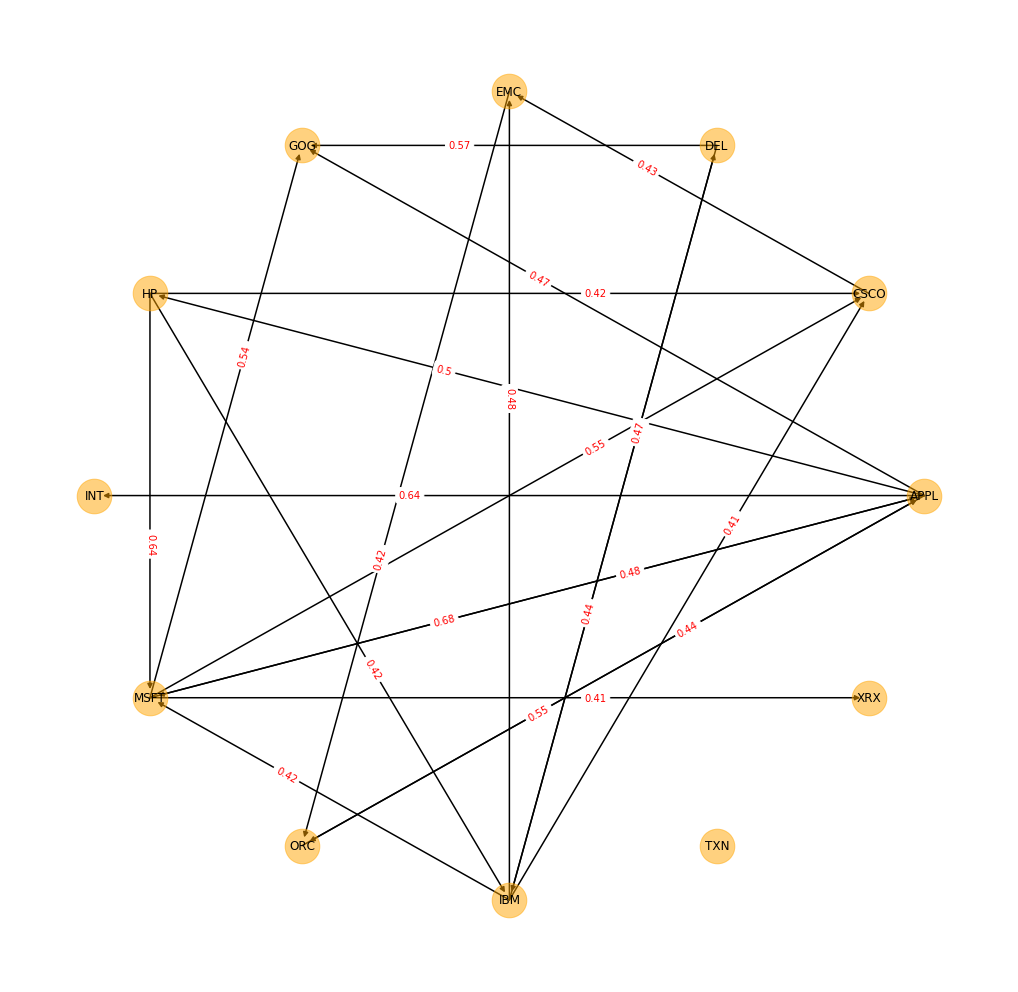

In [9]:
plt.figure(figsize=(18,18))
G = nx.from_numpy_matrix(np.matrix(DI_thresh), create_using=nx.DiGraph)
pos=nx.circular_layout(G) # positions for all nodes

# nodes
nx.draw_networkx_nodes(G,pos,nodelist=[0,1,2,3,4,5,6,7,8,9,10,11],node_color='orange',node_size=1200,alpha=0.5)

# edges
nx.draw_networkx_edges(G,pos,width=1.5,alpha=1.0)
edge_labels=dict([((u,v,),d['weight']) for u,v,d in G.edges(data=True)])
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels,label_pos = 0.38,font_color= 'r')

# some math labels
labels={}
labels[0]=r'APPL'
labels[1]=r'CSCO'
labels[2]=r'DEL'
labels[3]=r'EMC'
labels[4]=r'GOG'
labels[5]=r'HP'
labels[6]=r'INT'
labels[7]=r'MSFT'
labels[8]=r'ORC'
labels[9]=r'IBM'
labels[10]=r'TXN'
labels[11]=r'XRX'

nx.draw_networkx_labels(G,pos,labels,font_size=12)

plt.axis('off')
plt.savefig("labels_and_colors.png") # save as png
plt.show() # display